<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/FLOPS/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNet

# Evaluasi
#import torch
#import torchvision.models as models
#from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
corn-or-maize-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

replace /content/data/Blight/Corn_Blight (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset_dir = '/content/data'

In [ ]:
print(os.listdir(dataset_dir))

['Common_Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot']


In [2]:
IMAGE_SIZE_mobilenet = 224

In [ ]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_mobilenet, IMAGE_SIZE_mobilenet))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [ ]:
X = []
Z = []

In [ ]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:12<00:00, 89.35it/s] 


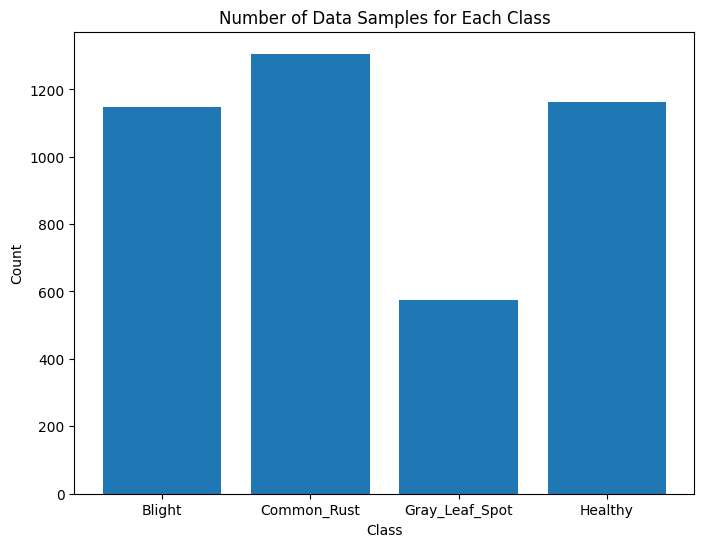

In [ ]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [ ]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

X = np.array(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [3]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE_mobilenet, IMAGE_SIZE_mobilenet, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the new model
model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary dari model
model_mobilenet.summary()

# Melatih model dengan data latih dan validasi
#history_mobilenet = model_mobilenet.fit(datagen.flow(X_train, Y_train), epochs=10, validation_data=(X_test, Y_test))

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

27/27 [==============================] - 1s 29ms/step


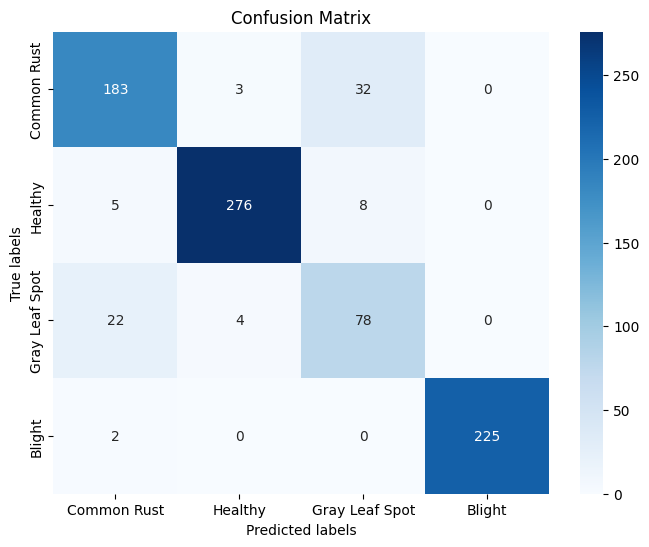


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       218
           1       0.98      0.96      0.97       289
           2       0.66      0.75      0.70       104
           3       1.00      0.99      1.00       227

    accuracy                           0.91       838
   macro avg       0.87      0.88      0.88       838
weighted avg       0.91      0.91      0.91       838



In [ ]:
Y_pred = model_mobilenet.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common Rust', 'Healthy', 'Gray Leaf Spot', 'Blight'], yticklabels=['Common Rust', 'Healthy', 'Gray Leaf Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)

In [ ]:
tf.compat.v1.disable_v2_behavior()

# Define the model
model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# Ensure the model is built and weights are loaded
model.build((None, 224, 224, 3))

# Run the function after the model is defined
def get_flops_params():
    sess_aha = tf.compat.v1.Session()
    with sess_aha.as_default():
        tf.compat.v1.keras.backend.set_session(sess_aha)
        model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        graph = sess_aha.graph
        flops = tf.compat.v1.profiler.profile(graph, options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())
        params = tf.compat.v1.profiler.profile(graph, options=tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter())
        if flops is not None and params is not None:
            print('FLOPs: {};    Trainable params: {}'.format(flops.total_float_ops, params.total_parameters))

get_flops_params()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
54 ops no flops stats due to incomplete shapes.
54 ops no flops stats due to incomplete shapes.


FLOPs: 12828066;    Trainable params: 6413952


In [4]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=1):
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([batch_size] + [dim for dim in model.input.shape[1:]], model.input.dtype))

    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                          run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

# Calculate FLOPs
flops = get_flops(model_mobilenet)
print(f"FLOPs: {flops}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPs: 1137589272
